 <font size='4'><b>Project 7 - Data Analysis </b></font> 

<a href="https://openclassrooms.com/en/" >Openclassrooms</a>, Data Analyst Course
<br>Project 7 by Michael Orange

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import pylab 

import scipy.cluster.hierarchy as hierarchy
from sklearn import preprocessing
from sklearn import decomposition
import sklearn.utils as utils

import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import kstest, norm

import json

from display_pca import *

[Uploads datasets](#import)

**Mission 1**
- [DataFrame income_disti](#income_disti)
- [DataFrame country_code](#country_code)
- [DataFrame Population](#population)
- [Missing data and anomalies in income_disti](#anomalies)
- [DataFrame GINI](#gini)

**Mission 2**
- [Select a panel of countries (clustering)](#clustering)
- [Plot: Average income (log) per quantiles](#income_quantile)
- [Plot: Lorenz curves](#lorenz)
- [Plot: Evolution of the GINI Index from 2008 to 2016](#gini_evo)
- [GINI Ranking (2007-2009)](#gini_rank)

<h2>Uploads </h2><a id='import'></a>

In [2]:
income_disti = pd.read_csv("data/raw/data-project7.csv")
pop = pd.read_csv("data/raw/pop.csv")
country_codes = pd.read_csv("data/raw/country_codes.csv")
gini_all = pd.read_csv("data/raw/gini.csv")
region = pd.read_csv("data/raw/region_country_worldbank.csv")
region_elasticity = pd.read_csv("data/raw/FAOSTAT_region_elasticity.csv")
elasticity = pd.read_csv('data/raw/elasticity_gdim.csv')

<h2>Mission 1</h2><a id='mission 1'></a>

<h3>DataFrame income_disti</h3><a id='income_disti'></a>

In [3]:
#converting "income" and "gdpppp" into float
income_disti["income"] = income_disti["income"].str.replace(',', '.').astype(float)
income_disti["gdpppp"] = income_disti["gdpppp"].str.replace(',', '.').astype(float)

In [4]:
income_disti.columns

Index(['country', 'year_survey', 'quantile', 'nb_quantiles', 'income',
       'gdpppp'],
      dtype='object')

In [5]:
income_disti.columns = ['country_alpha3', 'year_survey', 'quantile', 'nb_quantiles', 'income',
       'gdpppp']

income_disti

,country_alpha3,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.00000
1,ALB,2008,2,100,916.66235,7297.00000
2,ALB,2008,3,100,1010.91600,7297.00000
3,ALB,2008,4,100,1086.90780,7297.00000
4,ALB,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305
11595,COD,2008,97,100,911.78340,303.19305
11596,COD,2008,98,100,1057.80740,303.19305
11597,COD,2008,99,100,1286.60290,303.19305


In [6]:
'{} selected'.format(income_disti.year_survey.sort_values().unique())

'[2004 2006 2007 2008 2009 2010 2011] selected'

In [7]:
#list of countries in income_disti
country_income = income_disti.country_alpha3.unique()
'{} countries are in the dataframe income_disti'.format(len(country_income))

'116 countries are in the dataframe income_disti'

<h3>DataFrame country_code</h3><a id='country_code'></a>

In [8]:
country_code = country_codes[['official_name_en', 'ISO3166-1-Alpha-3']].copy()
country_code.columns = ['country', 'country_alpha3']
country_code

,country,country_alpha3
0,NaN,TWN
1,Afghanistan,AFG
2,Albania,ALB
3,Algeria,DZA
4,American Samoa,ASM
...,...,...
245,Western Sahara,ESH
246,Yemen,YEM
247,Zambia,ZMB
248,Zimbabwe,ZWE


In [9]:
#countries with no country description
country_code.loc[country_code.country.isna()].country_alpha3.unique()

array(['TWN'], dtype=object)

In [10]:
#Adding country name 'Taiwan' to TWN
country_code.loc[country_code['country_alpha3'] == 'TWN', 'country'] = 'Taiwan'

In [11]:
#countries in income_disti and not in country_code
for z in country_income:
    if z not in country_code.country_alpha3.unique():
        print(z)

XKX


In [12]:
#Adding XKX Kosovo
new_row = {'country':'Kosovo', 'country_alpha3':'XKX'}
country_code = country_code.append(new_row, ignore_index=True)

<h3>DataFrame Population</h3><a id='population'></a>

In [13]:
pop.columns

Index(['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element',
       'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value', 'Flag',
       'Flag Description', 'Note'],
      dtype='object')

In [14]:
pop

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2004,2004,1000 persons,24726.684,X,International reliable sources,NaN
1,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2006,2006,1000 persons,26433.049,X,International reliable sources,NaN
2,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2007,2007,1000 persons,27100.536,X,International reliable sources,NaN
3,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,27722.276,X,International reliable sources,NaN
4,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2009,2009,1000 persons,28394.813,X,International reliable sources,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2007,2007,1000 persons,12255.922,X,International reliable sources,NaN
1617,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2008,2008,1000 persons,12379.549,X,International reliable sources,NaN
1618,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2009,2009,1000 persons,12526.968,X,International reliable sources,NaN
1619,OA,Annual population,181,Zimbabwe,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2010,2010,1000 persons,12697.723,X,International reliable sources,NaN


In [15]:
pop.columns = ['Domain Code', 'Domain', 'country_code', 'country', 'Element Code', 'Element',
       'Item Code', 'Item', 'Year Code', 'year_survey', 'Unit', 'population', 'Flag',
       'Flag Description', 'Note']

In [16]:
pop['population'] = pop['population'] * 1000

In [17]:
pop = pop[['country', 'year_survey', 'population']]
pop

,country,year_survey,population
0,Afghanistan,2004,24726684.0
1,Afghanistan,2006,26433049.0
2,Afghanistan,2007,27100536.0
3,Afghanistan,2008,27722276.0
4,Afghanistan,2009,28394813.0
...,...,...,...
1616,Zimbabwe,2007,12255922.0
1617,Zimbabwe,2008,12379549.0
1618,Zimbabwe,2009,12526968.0
1619,Zimbabwe,2010,12697723.0


In [18]:
pop = pd.merge(pop, country_code, how='outer')

In [19]:
#countries with no population 
pop.loc[(pop['population'].isna())&(pop.country_alpha3.isin(country_income))]

,country,year_survey,population,country_alpha3
1621,Taiwan,NaN,NaN,TWN
1642,State of Palestine,NaN,NaN,PSE
1643,Sudan,NaN,NaN,SDN
1645,Swaziland,NaN,NaN,SWZ
1646,The former Yugoslav Republic of Macedonia,NaN,NaN,MKD
1649,Kosovo,NaN,NaN,XKX


In [20]:
#countries with no country code
#pop.loc[(pop['country_alpha3'].isna())&(~pop.population.isna())].country.unique()

In [21]:
#countries named differently on pop and country_code
country_dict = {'Taiwan':'China, Taiwan Province of', 'State of Palestine': 'Palestine', 
               'Sudan' : 'Sudan (former)','The former Yugoslav Republic of Macedonia' : 'North Macedonia'}

for key in country_dict:
    pop.loc[pop['country'] == country_dict[key], 'country'] = pop.loc[pop['country'] == key].country.values[0]
    pop.loc[pop['country'] == key, 'country_alpha3'] = pop.loc[
        (pop['country'] == key) & (~pop.country_alpha3.isna())].country_alpha3.values[0]
    pop.drop(pop.loc[(pop['country'] == key) & (pop.population.isna())].index, inplace=True)

In [22]:
#Adjusting the numbers for 'China' - Taiwan's population needs to be substracted
pop.loc[pop['country_alpha3'] == 'CHN', 'population'] = \
        pop.loc[pop['country_alpha3'] == 'CHN'].population.values - \
                pop.loc[pop['country_alpha3'] == 'TWN'].population.values

In [23]:
#deleting the countries not categorized
pop.drop(pop.loc[pop.country_alpha3.isna()].index, inplace=True)

In [24]:
#Countries both in DF pop and DF income_disti with no data for population 
pop[(pop.population.isna()) & (pop.country_alpha3.isin(income_disti.country_alpha3))]

,country,year_survey,population,country_alpha3
1645,Swaziland,NaN,NaN,SWZ
1649,Kosovo,NaN,NaN,XKX


In [25]:
# checking the year of survey for SWZ and XKX in DF income_disti
temp = pop[(pop.population.isna()) & (pop.country_alpha3.isin(income_disti.country_alpha3))]

income_disti[income_disti.country_alpha3.isin(temp.country_alpha3)].groupby(
    'country_alpha3').first()[['year_survey']]

,year_survey
country_alpha3,
SWZ,2009
XKX,2008


In [26]:
#imputing "Swaziland" (SWZ) and "Kosovo" (XKX) population data
pop.loc[pop['country_alpha3'] == 'SWZ', 'population'] = 1033000
pop.loc[pop['country_alpha3'] == 'SWZ', 'year_survey'] = 2009

pop.loc[pop['country_alpha3'] == 'XKX', 'population'] = 1747383
pop.loc[pop['country_alpha3'] == 'XKX', 'year_survey'] = 2008

#sources: 
## SWZ (https://countryeconomy.com/demography/population)
## XKX (https://data.worldbank.org)

In [27]:
#merge population and income_disti
income_disti = pd.merge(income_disti, pop, how='left')

<h3>income_disti : missing data and anomalies</h3><a id='anomalies'></a>

In [28]:
income_disti

,country_alpha3,year_survey,quantile,nb_quantiles,income,gdpppp,country,population
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0
...,...,...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305,Democratic Republic of the Congo,60411195.0
11595,COD,2008,97,100,911.78340,303.19305,Democratic Republic of the Congo,60411195.0
11596,COD,2008,98,100,1057.80740,303.19305,Democratic Republic of the Congo,60411195.0
11597,COD,2008,99,100,1286.60290,303.19305,Democratic Republic of the Congo,60411195.0


In [29]:
missing_data = []
for z in income_disti.country_alpha3.unique():
    nb_quant = len(income_disti.loc[income_disti.country_alpha3 == z])
    if nb_quant != 100:
        
        for k in list(range(1,101)): 
            if k not in income_disti.loc[income_disti.country_alpha3 == z]['quantile'].values:     
                missing_data += [('{} : {} quantiles, quantile {} missing'.format(z, nb_quant, k))]
missing_data

['LTU : 99 quantiles, quantile 41 missing']

In [30]:
#Imputing an approximation for quantile 41 based on the average between quantiles 42 and 40. 

ltu = income_disti.loc[income_disti.country_alpha3 == 'LTU']
ltu_41 = (ltu.loc[income_disti['quantile'] == 42].income.values 
            + ltu.loc[income_disti['quantile'] == 40].income.values) / 2 
'Approx value of quantile 41 : {}'.format(ltu_41)

'Approx value of quantile 41 : [4882.14065]'

In [31]:
#Adding quantile 41
new_row = {'country':'Lithuania', 'country_alpha3':'LTU', 'year_survey' : income_disti.loc[income_disti['country_alpha3'] == 'LTU'].year_survey.unique()[0],
           'quantile' : 41, 
           'nb_quantiles' : 100, 
           'income' : ltu_41[0], 
           'gdpppp' : income_disti.loc[income_disti.country_alpha3 == 'LTU']['gdpppp'].mean(),
           'country': 'Lithuania', 
           'population': income_disti.loc[income_disti.country_alpha3 == 'LTU']['population'].mean()}
income_disti = income_disti.append(new_row, ignore_index=True)

<AxesSubplot:xlabel='country_alpha3', ylabel='gdpppp'>

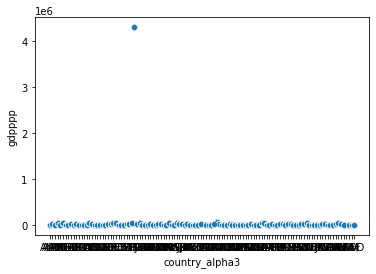

In [32]:
#checking outliers
sns.scatterplot(data = income_disti, x ='country_alpha3', y = 'gdpppp')

In [33]:
'{} GDP PPP of {} is an outlier'.format(income_disti.loc[income_disti.gdpppp > 4000000]['country'].unique()[0], 
                                        income_disti.loc[income_disti.gdpppp > 4000000]['year_survey'].unique()[0])

'Fiji GDP PPP of 2008 is an outlier'

In [34]:
# correcting GDP PPP 2008 of Fiji (source: data.worldbank.org)
income_disti.loc[income_disti['country'] == 'Fiji', 'gdpppp'] = 7777.69

In [35]:
#checking missing data in DF income_disti
for z in income_disti.columns:
    if not income_disti[income_disti[z].isnull() == True].empty: 
        temp = income_disti[income_disti[z].isnull() == True]
        dict_na = {}
        dict_na.update({z: temp.country_alpha3.unique()})

'Missing data : {}'.format(dict_na)

"Missing data : {'gdpppp': array(['XKX', 'PSE'], dtype=object)}"

In [36]:
# Imputation GDP PPP 2008 of XKX (Kosovo) and GDP PPP 2009 of PSE (Palestine) (source: data.worldbank.org.
income_disti.loc[income_disti['country'] == 'Kosovo', 'gdpppp'] = 3254.78
income_disti.loc[income_disti['country'] == 'State of Palestine', 'gdpppp'] = 4721.09

In [37]:
#total population covered by income_disti and % of the total world population
#an approximation is accepted based on the total population of 2008

WORLD_POP = 6758000000

income_pop = income_disti.groupby(['country_alpha3'])['population'].first().sum()
ratio_pop = income_pop / WORLD_POP

'Population of {} covered in income_disti, {} % of the world population'.format(int(income_pop), round(ratio_pop*100,2))

'Population of 6235407487 covered in income_disti, 92.27 % of the world population'

<h3>DataFrame GINI</h3><a id='gini'></a>

Data are consistently populated between 2004 and 2016.

In [38]:
gini_all

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN
3,Albania,ALB,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN
4,Andorra,AND,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,33.3,27.8,29.0,26.3,27.3,26.5,26.7,29.0,NaN,NaN
260,"Yemen, Rep.",YEM,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN
261,South Africa,ZAF,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,63.4,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN
262,Zambia,ZMB,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,55.6,NaN,NaN,NaN,NaN,57.1,NaN,NaN,NaN,NaN


In [39]:
gini_all.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019'],
      dtype='object')

In [40]:
gini_all.columns = ['country', 'country_alpha3', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019']

In [41]:
gini = gini_all[['country', 'country_alpha3', '2004', '2005','2006','2007', 
                 '2008', '2009', '2010', '2011', '2012',
                 '2013','2014','2015','2016']]

In [42]:
#remove countries not in income_disti
gini = gini.loc[gini.country_alpha3.isin(income_disti.country_alpha3.unique())].copy()
gini.reset_index(drop=True, inplace=True)

In [43]:
#country in Income but not in Gini
income_disti.loc[~income_disti.country_alpha3.isin(gini.country_alpha3.unique())].country_alpha3.unique()

array(['TWN'], dtype=object)

In [44]:
# Adding Taiwan
new_row = {'country':'Taiwan', 'country_alpha3':'TWN'}
#append row to the dataframe
gini = gini.append(new_row, ignore_index=True)

In [45]:
gini

,country,country_alpha3,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Albania,ALB,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,34.6,32.9,33.7
1,Argentina,ARG,48.6,48.0,46.7,46.6,45.3,44.1,44.5,42.7,41.4,41.0,41.7,NaN,42.0
2,Armenia,ARM,37.5,36.0,29.7,31.2,29.2,28.0,30.0,29.4,29.6,30.6,31.5,32.4,32.5
3,Austria,AUT,29.8,28.7,29.6,30.6,30.4,31.5,30.3,30.8,30.5,30.8,30.5,30.5,30.8
4,Azerbaijan,AZE,26.6,26.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Vietnam,VNM,36.8,NaN,35.8,NaN,35.6,NaN,39.3,NaN,35.6,NaN,34.8,NaN,35.3
112,Kosovo,XKX,NaN,31.2,30.3,NaN,NaN,31.8,33.3,27.8,29.0,26.3,27.3,26.5,26.7
113,"Yemen, Rep.",YEM,NaN,34.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.7,NaN,NaN
114,South Africa,ZAF,NaN,64.8,NaN,NaN,63.0,NaN,63.4,NaN,NaN,NaN,63.0,NaN,NaN


**Calculate GINI Index**

In [46]:
def calculate_gini(array):
    """Calculate the Gini coefficient """
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [47]:
#countries with no gini available for the specific 'year_survey' in DF income_disti

no_gini = []
for t in ['2004', '2005','2006','2007', '2008', '2009', '2010', '2011', '2012','2013','2014','2015','2016']:
    temp = gini.loc[(gini[t].isna()) 
        & (gini.country_alpha3.isin(income_disti.loc[
            income_disti['year_survey'] == int(t)].country_alpha3.unique()))].country_alpha3
    
    if temp.size >0 :
         no_gini.extend(temp)               

print(no_gini)

['GHA', 'CHN', 'IND', 'KEN', 'LKA', 'MAR', 'AZE', 'CAN', 'COD', 'HRV', 'IRN', 'IRQ', 'ISR', 'KHM', 'MKD', 'MNE', 'PAK', 'SRB', 'USA', 'XKX', 'YEM', 'TWN', 'EGY', 'MYS', 'MLI', 'NGA', 'GTM']


In [48]:
 #calculate GINI for the countries with no gini index
for z in no_gini:
    X = income_disti.loc[income_disti.country_alpha3 == z].income.values
        
    year_ref = income_disti[income_disti.country_alpha3 == z].year_survey.unique()[0]
        
    gini.loc[gini['country_alpha3'] == z, str(year_ref)] = (calculate_gini(X)*100).round(1)

In [49]:
gini[gini.country_alpha3=='GHA']

,country,country_alpha3,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
37,Ghana,GHA,NaN,42.8,42.8,NaN,NaN,NaN,NaN,NaN,42.4,NaN,NaN,NaN,43.5


**Merge GINI Index in income_disti**

In [50]:
gini

,country,country_alpha3,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Albania,ALB,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,34.6,32.9,33.7
1,Argentina,ARG,48.6,48.0,46.7,46.6,45.3,44.1,44.5,42.7,41.4,41.0,41.7,NaN,42.0
2,Armenia,ARM,37.5,36.0,29.7,31.2,29.2,28.0,30.0,29.4,29.6,30.6,31.5,32.4,32.5
3,Austria,AUT,29.8,28.7,29.6,30.6,30.4,31.5,30.3,30.8,30.5,30.8,30.5,30.5,30.8
4,Azerbaijan,AZE,26.6,26.6,NaN,NaN,31.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Vietnam,VNM,36.8,NaN,35.8,NaN,35.6,NaN,39.3,NaN,35.6,NaN,34.8,NaN,35.3
112,Kosovo,XKX,NaN,31.2,30.3,NaN,31.4,31.8,33.3,27.8,29.0,26.3,27.3,26.5,26.7
113,"Yemen, Rep.",YEM,NaN,34.7,NaN,NaN,37.4,NaN,NaN,NaN,NaN,NaN,36.7,NaN,NaN
114,South Africa,ZAF,NaN,64.8,NaN,NaN,63.0,NaN,63.4,NaN,NaN,NaN,63.0,NaN,NaN


In [51]:
income_disti

,country_alpha3,year_survey,quantile,nb_quantiles,income,gdpppp,country,population
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0
...,...,...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305,Democratic Republic of the Congo,60411195.0
11596,COD,2008,98,100,1057.80740,303.19305,Democratic Republic of the Congo,60411195.0
11597,COD,2008,99,100,1286.60290,303.19305,Democratic Republic of the Congo,60411195.0
11598,COD,2008,100,100,2243.12260,303.19305,Democratic Republic of the Congo,60411195.0


In [52]:
# adding gini in DF income_disti
for k in income_disti.country_alpha3: 
    
    year_ref = income_disti[income_disti.country_alpha3 == k]['year_survey'].unique()[0]

    income_disti.loc[income_disti['country_alpha3'] == k, 
                     'gini'] = gini[gini.country_alpha3 == k][str(year_ref)].values[0]

In [53]:
income_disti

,country_alpha3,year_survey,quantile,nb_quantiles,income,gdpppp,country,population,gini
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0,30.0
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0,30.0
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0,30.0
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0,30.0
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0,30.0
...,...,...,...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305,Democratic Republic of the Congo,60411195.0,44.4
11596,COD,2008,98,100,1057.80740,303.19305,Democratic Republic of the Congo,60411195.0,44.4
11597,COD,2008,99,100,1286.60290,303.19305,Democratic Republic of the Congo,60411195.0,44.4
11598,COD,2008,100,100,2243.12260,303.19305,Democratic Republic of the Congo,60411195.0,44.4


<h2>Mission 2</h2><a id='mission 2'></a>

<h3>Select a panel of countries (clustering)</h3><a id='clustering'></a>

In [54]:
data_pca = income_disti[['country', 'country_alpha3', 'gdpppp', 'population', 'gini']]

In [55]:
data_pca = data_pca.drop_duplicates(keep = 'first', inplace = False) 
data_pca

,country,country_alpha3,gdpppp,population,gini
0,Albania,ALB,7297.00000,3002678.0,30.0
100,Argentina,ARG,13220.00000,40080160.0,45.3
200,Armenia,ARM,5611.00000,2907618.0,29.2
300,Austria,AUT,36193.00000,8341532.0,30.4
400,Azerbaijan,AZE,8101.00000,8821873.0,31.2
...,...,...,...,...,...
11099,Viet Nam,VNM,2578.00000,84617540.0,35.8
11199,State of Palestine,PSE,4721.09000,3957670.0,34.5
11299,Yemen,YEM,2224.00000,21892146.0,37.4
11399,South Africa,ZAF,9602.00000,49779471.0,63.0


In [56]:
col = ['gdpppp', 'population', 'gini']
X = data_pca[col].values

In [57]:
#number of observations
n = X.shape[0]
# number of variables
p = X.shape[1]

In [58]:
# Normalization (mean centering and variance standardization to 1)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [59]:
# PCA
pca = decomposition.PCA(n_components=p)
pca.fit(X_scaled)

PCA(n_components=3)

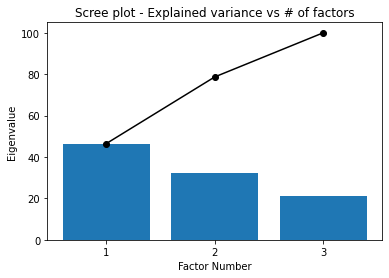

In [60]:
# Scree plot
fig = display_scree_plot(pca)
fig.savefig('data/output_graphics/scree_plot', transparent=True)

In [61]:
# number of component selected
n_comp = 2

In [62]:
# PCA
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=2)

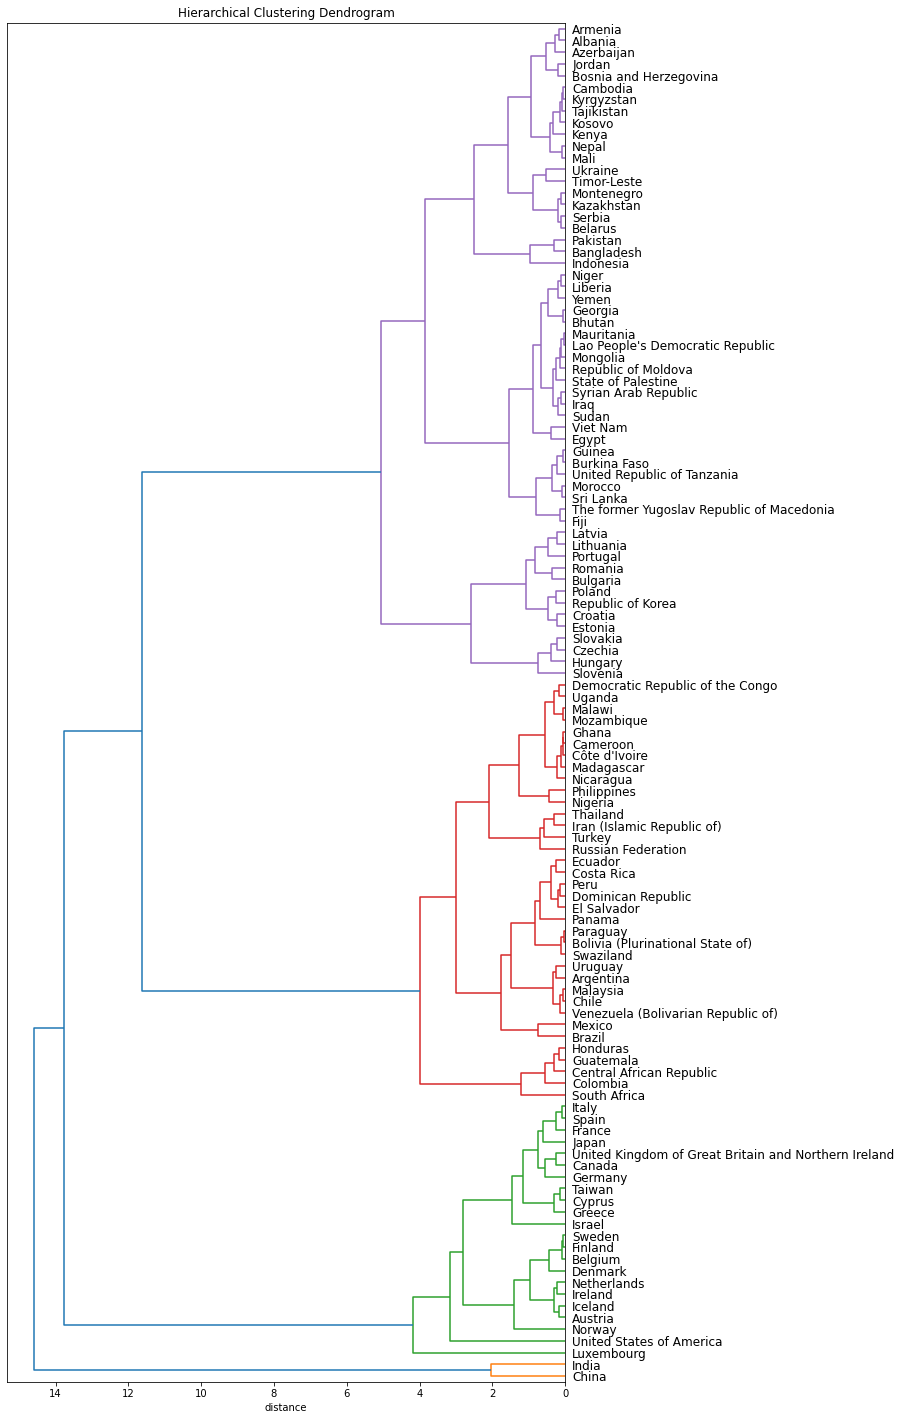

In [63]:
names = data_pca['country'].values

# Clustering hiérarchique
Z = hierarchy.linkage(X_scaled, 'ward')

#dendrogram
fig = plot_dendrogram(Z, names, orientation='top', display='no_display')
fig.savefig('data/output_graphics/dendogram', transparent=True)
plt.close(fig)

plot_dendrogram(Z, names, orientation='left')

In [64]:
num_clusters = 8
clusters = hierarchy.fcluster(Z, num_clusters, criterion='maxclust')

In [65]:
df_cluster = pd.DataFrame(clusters)
df_cluster.columns = ['cluster']
df_cluster.index=data_pca['country']
df_cluster.reset_index().pivot_table(index='cluster', values='country', aggfunc=len)

,country
cluster,
1,2
2,21
3,1
4,5
5,31
6,13
7,22
8,21


In [66]:
X_projected = pca.transform(X_scaled)

In [67]:
X_projected.shape

(116, 2)

In [68]:
df_X_projected = pd.DataFrame(X_projected, index=names, columns=['F'+str(i+1) for i in range(n_comp)])
df_X_projected = pd.concat([df_X_projected, df_cluster], axis=1)
df_X_projected.reset_index(inplace=True)
df_X_projected

,index,F1,F2,cluster
0,Albania,0.474386,-0.237957,8
1,Argentina,-0.560822,-0.201990,5
2,Armenia,0.454799,-0.255005,8
3,Austria,1.915383,0.323132,2
4,Azerbaijan,0.405774,-0.212284,8
...,...,...,...,...
111,Viet Nam,-0.387941,0.029541,7
112,State of Palestine,-0.035181,-0.364300,7
113,Yemen,-0.435351,-0.362980,7
114,South Africa,-2.240634,-0.543867,4


In [69]:
df_X_projected.columns = ['country', 'F1', 'F2', 'cluster']
df_X_projected

,country,F1,F2,cluster
0,Albania,0.474386,-0.237957,8
1,Argentina,-0.560822,-0.201990,5
2,Armenia,0.454799,-0.255005,8
3,Austria,1.915383,0.323132,2
4,Azerbaijan,0.405774,-0.212284,8
...,...,...,...,...
111,Viet Nam,-0.387941,0.029541,7
112,State of Palestine,-0.035181,-0.364300,7
113,Yemen,-0.435351,-0.362980,7
114,South Africa,-2.240634,-0.543867,4


In [70]:
centroids = df_X_projected.pivot_table(index='cluster', values=df_X_projected.columns[1:3], aggfunc=np.mean)
centroids

,F1,F2
cluster,,
1,-2.676241,6.690908
2,1.572606,0.431606
3,3.640638,0.925507
4,-1.951720,-0.664817
5,-0.976360,-0.326288
6,0.894159,-0.005710
7,-0.366761,-0.351617
8,0.245597,-0.101058


In [71]:
#distance from centroid 
for k in centroids.index: 
    df_X_projected.loc[df_X_projected['cluster'] == k, 'distance_centroid'] = np.sqrt(
    (df_X_projected['F1'] - centroids.loc[centroids.index == k]['F1'].values)**2  
    + (df_X_projected['F2'] - centroids.loc[centroids.index == k]['F2'].values)**2)

In [72]:
df_X_projected

,country,F1,F2,cluster,distance_centroid
0,Albania,0.474386,-0.237957,8,0.266618
1,Argentina,-0.560822,-0.201990,5,0.433731
2,Armenia,0.454799,-0.255005,8,0.259740
3,Austria,1.915383,0.323132,2,0.359531
4,Azerbaijan,0.405774,-0.212284,8,0.195007
...,...,...,...,...,...
111,Viet Nam,-0.387941,0.029541,7,0.381746
112,State of Palestine,-0.035181,-0.364300,7,0.331823
113,Yemen,-0.435351,-0.362980,7,0.069525
114,South Africa,-2.240634,-0.543867,4,0.313210


In [73]:
df_cluster.reset_index(inplace=True)
gini = pd.merge(gini, df_cluster, how='left')
gini.set_index('country', inplace=True)

In [74]:
gini

,country_alpha3,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cluster
country,,,,,,,,,,,,,,,
Albania,ALB,NaN,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,34.6,32.9,33.7,8.0
Argentina,ARG,48.6,48.0,46.7,46.6,45.3,44.1,44.5,42.7,41.4,41.0,41.7,NaN,42.0,5.0
Armenia,ARM,37.5,36.0,29.7,31.2,29.2,28.0,30.0,29.4,29.6,30.6,31.5,32.4,32.5,8.0
Austria,AUT,29.8,28.7,29.6,30.6,30.4,31.5,30.3,30.8,30.5,30.8,30.5,30.5,30.8,2.0
Azerbaijan,AZE,26.6,26.6,NaN,NaN,31.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,VNM,36.8,NaN,35.8,NaN,35.6,NaN,39.3,NaN,35.6,NaN,34.8,NaN,35.3,NaN
Kosovo,XKX,NaN,31.2,30.3,NaN,31.4,31.8,33.3,27.8,29.0,26.3,27.3,26.5,26.7,8.0
"Yemen, Rep.",YEM,NaN,34.7,NaN,NaN,37.4,NaN,NaN,NaN,NaN,NaN,36.7,NaN,NaN,NaN


In [75]:
#countries with GINI data available from 2008 to 20016 
gini_complete = gini.loc[(gini.iloc[:, 5:-1].isnull().sum(axis=1).values<1) &
                        (~gini.cluster.isna())]

#countries with 1 year of GINI data unavailable from 2008 to 20016 
gini_1_year_missing = gini.loc[(gini.iloc[:, 5:-1].isnull().sum(axis=1).values==1) &
                        (~gini.cluster.isna())]

In [76]:
gini_complete.loc[gini_complete.cluster == 2]

,country_alpha3,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cluster
country,,,,,,,,,,,,,,,
Austria,AUT,29.8,28.7,29.6,30.6,30.4,31.5,30.3,30.8,30.5,30.8,30.5,30.5,30.8,2.0
Belgium,BEL,30.5,29.3,28.1,29.2,28.4,28.6,28.4,28.1,27.5,27.7,28.1,27.7,27.6,2.0
Cyprus,CYP,30.1,30.3,31.1,31.1,31.7,32.1,31.5,32.6,34.3,37.0,35.6,34.0,32.9,2.0
Denmark,DNK,24.9,25.2,25.9,26.2,25.2,26.7,27.2,27.3,27.8,28.5,28.4,28.2,28.2,2.0
Spain,ESP,33.3,32.4,33.5,34.1,34.2,34.9,35.2,35.7,35.4,36.2,36.1,36.2,35.8,2.0
Finland,FIN,27.9,27.6,28.0,28.3,27.8,27.5,27.7,27.6,27.1,27.2,26.8,27.1,27.1,2.0
France,FRA,30.6,29.8,29.7,32.4,33.0,32.7,33.7,33.3,33.1,32.5,32.3,32.7,31.9,2.0
Greece,GRC,33.6,34.6,35.1,34.0,33.6,33.6,34.1,34.8,36.3,36.1,35.8,36.0,35.0,2.0
Ireland,IRL,33.6,33.8,32.7,31.9,30.9,32.7,32.3,32.9,33.2,33.5,31.9,31.8,32.8,2.0


In [77]:
for k in sorted(gini.cluster.dropna().unique()):
    if gini_complete.loc[gini_complete.cluster == k].index.values.size == 0: 
        gini_complete = gini_complete.append(gini_1_year_missing.loc[gini_1_year_missing.cluster == k])

In [78]:
gini_complete.loc[gini_complete.cluster == 1].index.size

1

In [79]:
#countries with GINI data available from 2008 to 20016 
gini_complete = gini.loc[(gini.iloc[:, 5:-1].isnull().sum(axis=1).values<1) &
                        (~gini.cluster.isna())]

#countries with 1 year of GINI data unavailable from 2008 to 20016 
gini_1_year_missing = gini.loc[(gini.iloc[:, 5:-1].isnull().sum(axis=1).values==1) &
                        (~gini.cluster.isna())]

#if no country with all data available from 2008 to 2016 in one cluster, then take a country with only 1 year missing
for k in sorted(gini.cluster.dropna().unique()):
    if gini_complete.loc[gini_complete.cluster == k].index.size == 0: 
        gini_complete = gini_complete.append(gini_1_year_missing.loc[gini_1_year_missing.cluster == k])
        
        
#sorted by clusters
for k in sorted(gini.cluster.dropna().unique()):
    print('cluster {}: {}'.format(k, gini_complete.loc[gini_complete.cluster == k].index.values))

cluster 1.0: ['China']
cluster 2.0: ['Austria' 'Belgium' 'Cyprus' 'Denmark' 'Spain' 'Finland' 'France'
 'Greece' 'Ireland' 'Italy' 'Netherlands' 'Norway' 'Sweden']
cluster 3.0: ['Luxembourg']
cluster 4.0: ['Colombia' 'Honduras']
cluster 5.0: ['Costa Rica' 'Dominican Republic' 'Ecuador' 'Panama' 'Peru' 'Paraguay'
 'Russian Federation' 'El Salvador' 'Thailand' 'Turkey' 'Uruguay']
cluster 6.0: ['Bulgaria' 'Estonia' 'Croatia' 'Hungary' 'Lithuania' 'Latvia' 'Poland'
 'Portugal' 'Romania' 'Slovenia']
cluster 7.0: ['Georgia']
cluster 8.0: ['Armenia' 'Belarus' 'Indonesia' 'Kazakhstan' 'Ukraine' 'Kosovo']


In [80]:
#countries within df_X_projected with the correct amount of completion
df_X_projected_completed = df_X_projected.loc[df_X_projected.country.isin(gini_complete.index)]

country_selected = []

#for each cluster, select the country the closest of the cluster's centroid
for k in sorted(gini_complete.cluster.unique()):

    #minimal distance from the centroid of the cluster
    min_distance = np.min(df_X_projected_completed.loc[(df_X_projected_completed.cluster == k)].distance_centroid)

    #country the closest of the cluster's centroid
    select = df_X_projected_completed.loc[(df_X_projected_completed.cluster ==k) &
                             (df_X_projected_completed.distance_centroid == min_distance)].country.values[0]
    country_selected.append(select)

country_selected

['China',
 'France',
 'Luxembourg',
 'Honduras',
 'Peru',
 'Estonia',
 'Georgia',
 'Armenia']

<h3>Plot: Average income (log) per quantiles</h3><a id='income_quantile'></a>

In [81]:
#styles
sns.set_style("darkgrid")

In [82]:
select_quantile = income_disti[['country', 'quantile', 'income']]
select_quantile = select_quantile.loc[select_quantile['country'].isin(country_selected)]
select_quantile = select_quantile.pivot_table(
    index=['quantile'], columns = ["country"], values=["income"], aggfunc=sum)

In [83]:
select_quantile

income                                                      \
country      Armenia         China     Estonia       France      Georgia   
quantile                                                                   
1          366.61780     16.719418    959.5601    2958.3040    97.541626   
2          535.32733    234.150730   1535.6865    4412.6753   166.974690   
3          611.64560    282.894900   1983.6115    4939.6350   210.756670   
4          658.33940    323.826500   2254.5150    5422.9165   243.505660   
5          690.84710    362.260600   2501.7200    5906.5376   272.576570   
...              ...           ...         ...          ...          ...   
96        3229.55370   7588.195000  16515.1910   39873.5100  3477.766800   
97        3466.66500   8317.553000  17683.1620   43693.0350  3818.964800   
98        3758.60180   9382.284000  18962.2620   49489.5820  4254.671400   
99        4320.28960  11071.510000  21533.0180   60758.6130  5006.603500   
100       6566.15900  17091.404000  32201.1390  122775.1640  8057.186000   

                                                  
country       Honduras   Luxembourg         Peru  
quantile                                          
1            50.166843    5780.8374    172.70412  
2            98.061290    7315.2686    297.08900  
3           138.908390    7891.2456    362.47195  
4           172.708790    8312.0310    407.27008  
5           204.631030    8945.6380    446.69992  
...                ...          ...          ...  
96        10820.309000   53724.6300   9855.69800  
97        12523.644000   58382.3120  10990.20100  
98        15031.881000   65280.2200  13095.76900  
99        19564.543000   77673.3700  16630.80000  
100       56265.700000  114823.6800  30853.23000  

[100 rows x 8 columns]

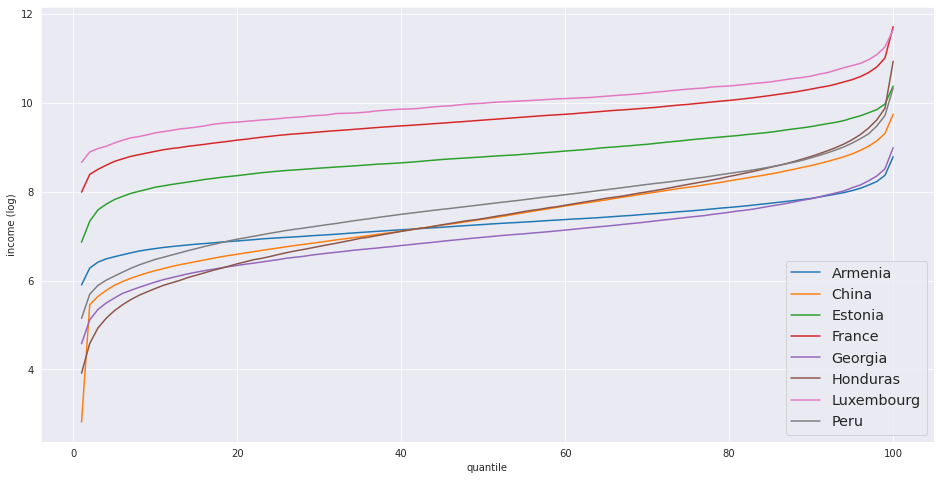

In [84]:
fig = plt.figure(figsize=(16,8))

for k in range(select_quantile.shape[1]): 
    plt.plot(np.log(select_quantile[select_quantile.columns[k]]), label=select_quantile.columns[k][1])

plt.grid(True)
plt.legend(loc='lower right',fontsize = 'x-large')
plt.xlabel('quantile')
plt.ylabel('income (log)')
plt.show()

<h3>Plot: Lorenz curves</h3><a id='lorenz'></a>

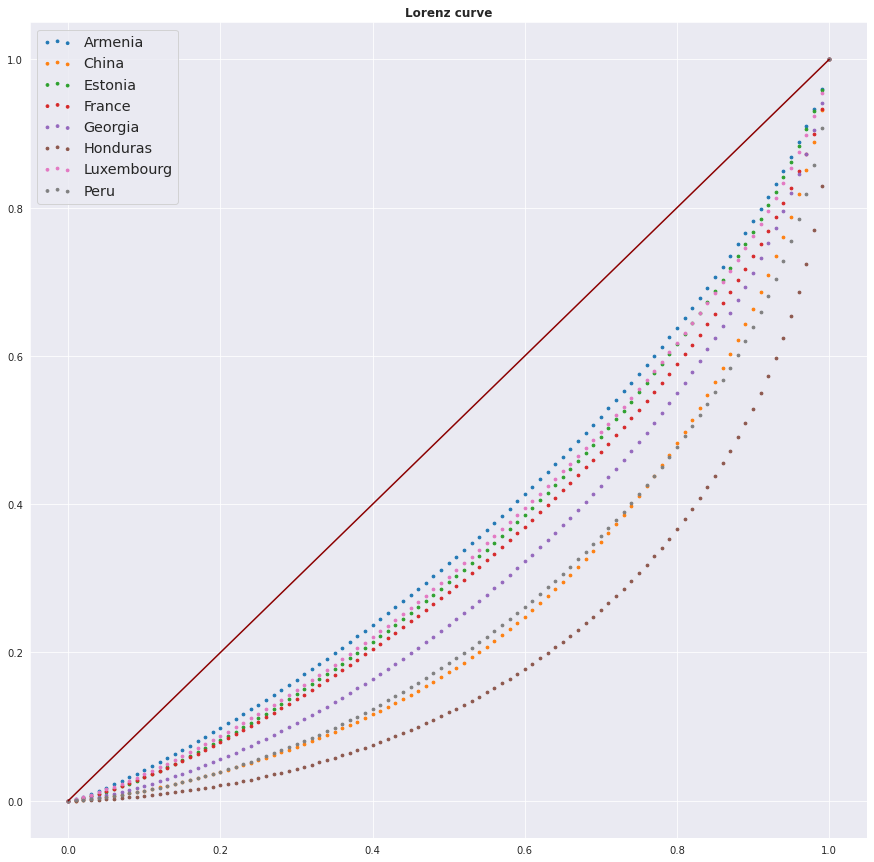

In [85]:
def lorenz_curve(X):
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    return X_lorenz

fig, ax = plt.subplots(1, 1, figsize=(15,15))
legend = []


for k in range(select_quantile.shape[1]): 
    income_sorted = select_quantile[select_quantile.columns[k]].sort_values(ascending=True)
    lorenz = lorenz_curve(income_sorted.values)
    x = np.arange(len(lorenz))/(len(lorenz)-1)
    
    ax.scatter(x, lorenz, marker='.', s=30, cmap=sns.color_palette())
    legend.append(select_quantile.columns[k][1])
    ax.legend(legend, loc='upper left', fontsize = 'x-large', scatterpoints = 3)
    
ax.plot([0,1], [0,1], color = '#8B0000')
plt.title("Lorenz curve", weight = 'bold')

plt.savefig('data/output_graphics/fig_lorenz.png', transparent=True)
plt.show()

<h3>Plot: Evolution of the GINI Index from 2008 to 2016</h3><a id='gini_evo'></a>

In [86]:
select_gini = gini_complete.loc[gini_complete.index.isin(country_selected)]
select_gini = select_gini.drop(['2004', '2005', '2006', '2007', 
                                'country_alpha3', 'cluster'], axis=1)
select_gini = select_gini.transpose()
select_gini

country,Armenia,Estonia,France,Georgia,Honduras,Luxembourg,Peru,China
2008,29.2,31.9,33.0,38.5,55.5,32.6,47.5,43.0
2009,28.0,31.4,32.7,38.2,51.3,31.2,47.0,NaN
2010,30.0,32.0,33.7,39.5,53.1,30.5,45.5,43.7
2011,29.4,32.5,33.3,39.6,56.2,32.1,44.7,42.4
2012,29.6,32.9,33.1,39.0,56.1,34.3,44.4,42.2
2013,30.6,35.1,32.5,38.6,52.6,32.0,43.9,39.7
2014,31.5,34.6,32.3,37.6,50.4,31.2,43.2,39.2
2015,32.4,32.7,32.7,36.5,49.6,33.8,43.4,38.6
2016,32.5,31.2,31.9,36.6,51.1,33.0,43.6,38.5


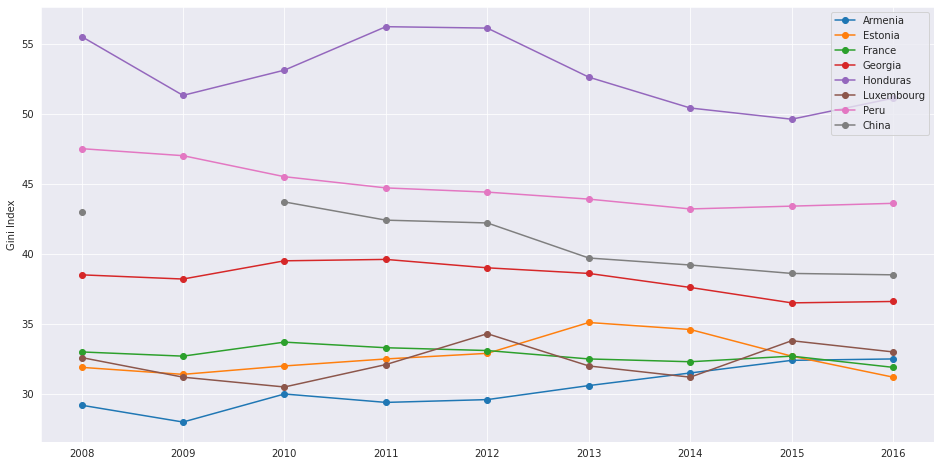

In [87]:
fig = plt.figure(figsize=(16,8))

for k in range(select_gini.shape[1]): 
    plt.plot(select_gini[select_gini.columns[k]],"-o", label=select_gini.columns[k])

plt.grid(True)
plt.legend(loc='upper right')
plt.ylabel('Gini Index')
plt.show()

<h3>GINI Ranking (2004-2016)</h3><a id='gini_rank'></a>

In [88]:
'Mean of GINI Index for the {} countries with available data : {}'.format(
    len(income_disti.country_alpha3.unique()), round(np.mean(income_disti['gini']),1))

'Mean of GINI Index for the 116 countries with available data : 37.8'

In [89]:
gini_by_country = income_disti[['country_alpha3', 'country', 'gini']].groupby(['country_alpha3']).first()
gini_by_country.reset_index(inplace=True)
gini_by_country.sort_values(by = 'gini', inplace=True)
gini_by_country

,country_alpha3,country,gini
97,SVN,Slovenia,23.7
26,DNK,Denmark,25.2
96,SVK,Slovakia,26.0
24,CZE,Czechia,26.3
108,UKR,Ukraine,26.6
...,...,...,...
21,COL,Colombia,55.5
41,HND,Honduras,55.5
14,CAF,Central African Republic,56.2
40,GTM,Guatemala,56.8


In [90]:
# 5 countries with higest GINI index (highest level of inequality)
gini_by_country.nlargest(5, 'gini')

,country_alpha3,country,gini
115,ZAF,South Africa,63.0
40,GTM,Guatemala,56.8
14,CAF,Central African Republic,56.2
21,COL,Colombia,55.5
41,HND,Honduras,55.5


In [91]:
# 5 countries with lowest GINI index (highest level of equality)
gini_by_country.nsmallest(5, 'gini')

,country_alpha3,country,gini
97,SVN,Slovenia,23.7
26,DNK,Denmark,25.2
96,SVK,Slovakia,26.0
24,CZE,Czechia,26.3
108,UKR,Ukraine,26.6


In [92]:
# France
'France Gini Index is {}, ranked {} over {} countries'.format(
    gini_by_country.loc[gini_by_country.country_alpha3 =='FRA']['gini'].values, 
    gini_by_country.loc[gini_by_country['country_alpha3']=='FRA'].index[0], 
    len(gini_by_country))

'France Gini Index is [33.], ranked 34 over 116 countries'

<h2>Mission 3</h2><a id='mission 3'></a>

<h3>Elasticity</h3><a id='elasticity'></a>

Coefficients of intergenerational elasticity between parents’ and children’s income are available through: 
- An estimation for each region (<a href="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/projet_7.zip" >multiple sources</a>)
- Coefficients by country from the World Bank, not all countries are available (<a href="https://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim" >GDIM sources</a>)

A combination of these 2 datasets is used (cofficient of the country when it is available, otherwise region estimator)

In [93]:
# Segmentation of countries by region
region_elasticity = region_elasticity[['Country Group', 'ISO3 Code']]
region_elasticity.columns = ['region_elasticity', 'country_alpha3']

In [94]:
# Imputation region to 'income_disti'
region_elasticity = region_elasticity.loc[region_elasticity.region_elasticity.isin(['Africa',  'Latin America and the Caribbean', 'Northern America',  'Asia', 
                                                     'Northern Europe', 'Western Europe', 'Eastern Europe', 'Southern Europe',  
                                                     'Oceania excluding Australia and New Zealand', 'Australia and New Zealand'])]
income_disti = pd.merge(income_disti, region_elasticity, how='left')

In [95]:
#imputation region to Kosovo
income_disti.loc[income_disti['country'] == 'Kosovo', 'region_elasticity'] = 'Southern Europe'

**Imputation : coefficients by region**

In [96]:
income_disti

,country_alpha3,year_survey,quantile,nb_quantiles,income,gdpppp,country,population,gini,region_elasticity
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0,30.0,Southern Europe
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0,30.0,Southern Europe
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0,30.0,Southern Europe
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0,30.0,Southern Europe
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0,30.0,Southern Europe
...,...,...,...,...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305,Democratic Republic of the Congo,60411195.0,44.4,Africa
11596,COD,2008,98,100,1057.80740,303.19305,Democratic Republic of the Congo,60411195.0,44.4,Africa
11597,COD,2008,99,100,1286.60290,303.19305,Democratic Republic of the Congo,60411195.0,44.4,Africa
11598,COD,2008,100,100,2243.12260,303.19305,Democratic Republic of the Congo,60411195.0,44.4,Africa


In [97]:
#region classification based on elasticity
income_disti.loc[income_disti['region_elasticity'].isin(['Western Europe', 'Eastern Europe', 'Southern Europe']), 
                 'region_elasticity']= 'Europe (except Northern Europe)'
income_disti.loc[(income_disti['region_elasticity'] == 'Northern Europe') 
                 | (income_disti.country == 'Canada'), 'region_elasticity'] = 'Northern Europe and Canada'
income_disti.loc[(income_disti['region_elasticity'] == 'Australia and New Zealand') 
                 | (income_disti.country == 'United States of America'), 'region_elasticity'] = 'Australia/New Zealand/USA'
income_disti.loc[income_disti['region_elasticity'] == 'Oceania', 'region_elasticity'] = 'Asia'

In [98]:
income_disti

,country_alpha3,year_survey,quantile,nb_quantiles,income,gdpppp,country,population,gini,region_elasticity
0,ALB,2008,1,100,728.89795,7297.00000,Albania,3002678.0,30.0,Europe (except Northern Europe)
1,ALB,2008,2,100,916.66235,7297.00000,Albania,3002678.0,30.0,Europe (except Northern Europe)
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,3002678.0,30.0,Europe (except Northern Europe)
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,3002678.0,30.0,Europe (except Northern Europe)
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,3002678.0,30.0,Europe (except Northern Europe)
...,...,...,...,...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305,Democratic Republic of the Congo,60411195.0,44.4,Africa
11596,COD,2008,98,100,1057.80740,303.19305,Democratic Republic of the Congo,60411195.0,44.4,Africa
11597,COD,2008,99,100,1286.60290,303.19305,Democratic Republic of the Congo,60411195.0,44.4,Africa
11598,COD,2008,100,100,2243.12260,303.19305,Democratic Republic of the Congo,60411195.0,44.4,Africa


In [99]:
#Coefficients of intergenerational elasticity between parents’ and children’s income (sources: elasticity.txt)
dic_elasticity = {'Northern Europe and Canada' : 0.2, 'Europe (except Northern Europe)' : 0.4, 
                  'Australia/New Zealand/USA' : 0.4, 'Asia' : 0.5, 'Latin America and the Caribbean' : 0.66, 'Africa': 0.66, 
                  'Oceania excluding Australia and New Zealand' : 0.66}

for key in dic_elasticity:
    income_disti.loc[income_disti.region_elasticity == key, 'elasticity'] = dic_elasticity[key]

**Imputation : coefficients by country**

In [100]:
#data from Global Database on Intergenerational Mobility (GDIM)
elasticity = elasticity[['iso3', 'IGEincome']]
elasticity.columns = ['country_alpha3', 'elasticity']
elasticity = elasticity.loc[~elasticity.elasticity.isna()]
elasticity = elasticity.groupby(['country_alpha3']).first()
elasticity.reset_index(inplace=True)

In [101]:
#replacing the regional coefficients by the country coefficients when available
for k in elasticity.country_alpha3: 
        income_disti.loc[income_disti.country_alpha3 == k, 'elasticity'] = np.round(
            elasticity.loc[elasticity.country_alpha3 == k].elasticity.values[0],2)

<h3>Functions</h3><a id='functions'></a>

In [102]:
def generate_incomes(n, pj):
# On génère les revenus des parents (exprimés en logs) selon une loi normale.
# La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)

    ln_y_parent = st.norm(0,1).rvs(size=n)

    #Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

In [106]:
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

In [108]:
def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

In [109]:
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()

    if total == 0 :
        return [0] * nb_quantiles

    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
    
        else:
            distrib += [0]
    
    return distrib

In [110]:
def conditional_distributions(sample, nb_quantiles):

    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()

    counts.columns = ["c_i_child","c_i_parent","counts"]

    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:

        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat)

In [111]:
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure(figsize=(16,8))

    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label= str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()

In [112]:
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

<h3>Protocol for a test country</h3><a id='protocol'></a>

In [113]:
pj = 0.9 # elasticity coefficient
NB_QUANTILES = 10 # number of class
n = 1000*NB_QUANTILES # sample size

In [114]:
y_child, y_parents = generate_incomes(n, pj)

In [115]:
sample = compute_quantiles(y_child, y_parents, NB_QUANTILES)
sample

,y_child,y_parents,c_i_child,c_i_parent
0,0.298851,2.580096,2,9
1,0.198340,0.245056,2,1
2,12.934833,15.630437,10,10
3,2.249584,0.670723,8,4
4,0.259828,1.614687,2,7
...,...,...,...,...
9995,0.544790,0.935316,4,5
9996,0.448388,0.708873,3,4
9997,0.780234,0.650589,5,4
9998,2.187871,2.300864,8,8


In [116]:
cd = conditional_distributions(sample, NB_QUANTILES)

In [117]:
#X-axis is parents, Y-axis is child
pd.DataFrame(cd)

,0,1,2,3,4,5,6,7,8,9
0,0.424,0.237,0.148,0.079,0.047,0.033,0.012,0.012,0.006,0.002
1,0.207,0.183,0.185,0.127,0.094,0.081,0.063,0.040,0.014,0.006
2,0.150,0.154,0.152,0.143,0.128,0.095,0.077,0.055,0.037,0.009
3,0.086,0.138,0.148,0.141,0.149,0.106,0.096,0.074,0.036,0.026
4,0.056,0.112,0.104,0.132,0.147,0.135,0.117,0.099,0.063,0.035
5,0.031,0.086,0.104,0.134,0.115,0.126,0.136,0.100,0.112,0.056
6,0.034,0.047,0.064,0.094,0.105,0.148,0.135,0.155,0.147,0.071
7,0.007,0.034,0.055,0.082,0.111,0.113,0.136,0.176,0.172,0.114
8,0.004,0.006,0.031,0.048,0.060,0.114,0.130,0.164,0.212,0.231
9,0.001,0.003,0.009,0.020,0.044,0.049,0.098,0.125,0.201,0.450


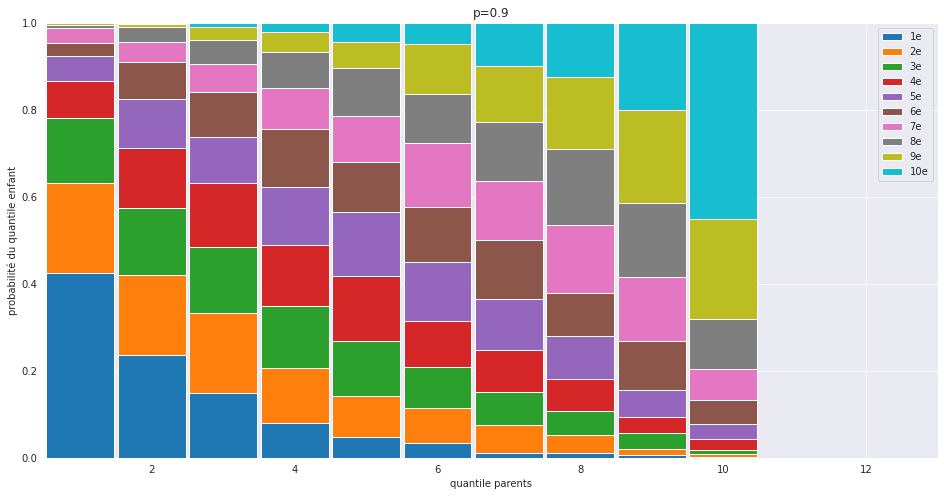

In [118]:
plot_conditional_distributions(pj, cd, NB_QUANTILES)

In [119]:
del sample, y_child, y_parents

<h3>World simulation</h3><a id='simulation'></a>

In [120]:
#create a sample of individuals by cloning 'income_disti' by 1000
CLONE_FACTOR = 1000

pop_sample = pd.concat([income_disti]*CLONE_FACTOR, ignore_index=True)
pop_sample = pop_sample[['country_alpha3',  'country', 'quantile', 'income', 'gdpppp', 'elasticity', 'gini']]
pop_sample.columns = ['country_alpha3', 'country', 'c_child', 'child_income', 'gdpppp', 'elasticity', 'gini']

In [121]:
pop_sample

,country_alpha3,country,c_child,child_income,gdpppp,elasticity,gini
0,ALB,Albania,1,728.89795,7297.00000,0.82,30.0
1,ALB,Albania,2,916.66235,7297.00000,0.82,30.0
2,ALB,Albania,3,1010.91600,7297.00000,0.82,30.0
3,ALB,Albania,4,1086.90780,7297.00000,0.82,30.0
4,ALB,Albania,5,1132.69970,7297.00000,0.82,30.0
...,...,...,...,...,...,...,...
11599995,COD,Democratic Republic of the Congo,97,911.78340,303.19305,0.71,44.4
11599996,COD,Democratic Republic of the Congo,98,1057.80740,303.19305,0.71,44.4
11599997,COD,Democratic Republic of the Congo,99,1286.60290,303.19305,0.71,44.4
11599998,COD,Democratic Republic of the Congo,100,2243.12260,303.19305,0.71,44.4


In [122]:
pop_sample[(pop_sample.c_child == 2)&(pop_sample.country_alpha3=='FRA')]

,country_alpha3,country,c_child,child_income,gdpppp,elasticity,gini
3301,FRA,France,2,4412.6753,30357.0,0.36,33.0
14901,FRA,France,2,4412.6753,30357.0,0.36,33.0
26501,FRA,France,2,4412.6753,30357.0,0.36,33.0
38101,FRA,France,2,4412.6753,30357.0,0.36,33.0
49701,FRA,France,2,4412.6753,30357.0,0.36,33.0
...,...,...,...,...,...,...,...
11545301,FRA,France,2,4412.6753,30357.0,0.36,33.0
11556901,FRA,France,2,4412.6753,30357.0,0.36,33.0
11568501,FRA,France,2,4412.6753,30357.0,0.36,33.0
11580101,FRA,France,2,4412.6753,30357.0,0.36,33.0


In [123]:
# function of the dictionary: conditional table for each pj (coefficient of elasticity) 
dict_pj = {}
NB_QUANTILES = 100 # number of class
n = CLONE_FACTOR*NB_QUANTILES # size of the sample

def calculate_cd_by_pj(pj_list, nb_class, sample_size): 
    for pj in pj_list:
        y_child, y_parents = generate_incomes(n, pj)
        sample = compute_quantiles(y_child, y_parents, nb_class)
        cd = conditional_distributions(sample, nb_class)
        dict_pj.update({pj: cd.tolist()})
    
    return dict_pj
 
#creating dictionary    
#dict_pj_export = calculate_cd_by_pj(pop_sample.elasticity.unique(), NB_QUANTILES, n)
    
#with open('data/output/dict_pj.json', 'w') as json_file:
    #json.dump(dict_pj_export, json_file)

In [124]:
with open('data/output/dict_pj.json', 'r') as json_file:
    json_read = json.load(json_file)

dict_pj = {}
for pj, cd in json_read.items():
    dict_pj.update({float(pj): cd})

In [125]:
pop_sample

,country_alpha3,country,c_child,child_income,gdpppp,elasticity,gini
0,ALB,Albania,1,728.89795,7297.00000,0.82,30.0
1,ALB,Albania,2,916.66235,7297.00000,0.82,30.0
2,ALB,Albania,3,1010.91600,7297.00000,0.82,30.0
3,ALB,Albania,4,1086.90780,7297.00000,0.82,30.0
4,ALB,Albania,5,1132.69970,7297.00000,0.82,30.0
...,...,...,...,...,...,...,...
11599995,COD,Democratic Republic of the Congo,97,911.78340,303.19305,0.71,44.4
11599996,COD,Democratic Republic of the Congo,98,1057.80740,303.19305,0.71,44.4
11599997,COD,Democratic Republic of the Congo,99,1286.60290,303.19305,0.71,44.4
11599998,COD,Democratic Republic of the Congo,100,2243.12260,303.19305,0.71,44.4


In [127]:
pop_sample.sort_values(by=['country_alpha3', 'c_child'], inplace=True)
pop_sample

,country_alpha3,country,c_child,child_income,gdpppp,elasticity,gini
0,ALB,Albania,1,728.89795,7297.0,0.82,30.0
11600,ALB,Albania,1,728.89795,7297.0,0.82,30.0
23200,ALB,Albania,1,728.89795,7297.0,0.82,30.0
34800,ALB,Albania,1,728.89795,7297.0,0.82,30.0
46400,ALB,Albania,1,728.89795,7297.0,0.82,30.0
...,...,...,...,...,...,...,...
11553498,ZAF,South Africa,100,82408.55000,9602.0,0.68,63.0
11565098,ZAF,South Africa,100,82408.55000,9602.0,0.68,63.0
11576698,ZAF,South Africa,100,82408.55000,9602.0,0.68,63.0
11588298,ZAF,South Africa,100,82408.55000,9602.0,0.68,63.0


In [ ]:
# number of child by class (c_child) is the same for each country
NB_CHILD_BY_CLASS = 1* CLONE_FACTOR

# calculate parents class based on elasticity and child class: 
pop_sample.sort_values(by=['country_alpha3', 'c_child'], inplace=True)

dict_parents_by_pj = {}

for pj in pop_sample.elasticity.unique():    
    dict_pj_selected = np.array(dict_pj[pj])    
    
    list_parents = []
        
    for child in range(dict_pj_selected.shape[0]): 
                        
        for parents in range(dict_pj_selected.shape[1]):
                
            list_parents.extend([parents+1]*int(NB_CHILD_BY_CLASS*dict_pj_selected[child][parents]) )
     
    for country in pop_sample.loc[pop_sample.elasticity == pj].country_alpha3.unique():
        pop_sample.loc[pop_sample.country_alpha3 == country, 'c_parents'] = list_parents

In [186]:
dict_parents_by_pj = {}
NB_CHILD_BY_CLASS = 15

pj = 0.15

dict_pj_selected = np.array(dict_pj[pj])    
    
list_parents = []
        
for child in range(dict_pj_selected.shape[0]): 
                        
    for parents in range(dict_pj_selected.shape[1]):
                
        list_parents.extend([parents+1]*int(NB_CHILD_BY_CLASS*dict_pj_selected[child][parents]) )

In [ ]:
pop_sample

In [ ]:
# graphic verification of c_parents results, exemple with France (pj = 0.36) and c_child = 32 
france_child32 = pop_sample[(pop_sample.country_alpha3 == 'FRA') & (pop_sample.c_child == 32)]
france_child32_cd = pd.DataFrame(dict_pj[0.36]).iloc[31]

fig, ax1 = plt.subplots(figsize = (14, 5))
                         
x = range(1, len(france_child32.c_parents.unique())+1)

color = 'tab:red'
ax1.set_xlabel('Class Parents')
ax1.set_ylabel('Theoritical values of Class Parents (cd)', color=color)
ax1.plot(x, france_child32_cd, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Calculated values of Class Parents', color=color) 
ax2.scatter(x, france_child32.groupby(['c_parents']).c_child.count())
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Class Parents - theoritical values vs calculated values (France, Class Child = 32)', fontsize=14)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# removing randomly half of the individuals (we only need 50 000 individuals for each country)
remove_n = 50000
drop_indices = []

for country in pop_sample.country_alpha3.unique(): 
    drop = np.random.choice(pop_sample.loc[pop_sample.country_alpha3==country].index, remove_n, replace=False)
    drop_indices.extend(drop)
                                                                                          
pop_sample = pop_sample.drop(drop_indices)

In [ ]:
# income based on class
income_by_class = income_disti[['country_alpha3', 'quantile', 'income']]
income_by_class.columns = ['country_alpha3', 'c_parents', 'parents_income']
income_by_class

# add parents income based on c_parents
pop_sample = pd.merge(pop_sample, income_by_class, how='left')

In [ ]:
#deleting c_child (not required later)
pop_sample.drop(columns=['c_child'], inplace=True)

In [ ]:
pop_sample

<h2>Mission 4</h2><a id='mission 4'></a>

<h3>One-way ANOVA - correlation between Country and Child_income</h3><a id='anova'></a>

H0 : There is no correlation between country and child_income (μ 0 = μ 1 = μ 2 = ...)
<br>H1 : There is a correlation between country and child_income

In [ ]:
income_anova = pop_sample[['country_alpha3', 'child_income']]
income_anova

In [ ]:
fig, ax1 = plt.subplots(figsize = (16, 5))

X = income_anova.country_alpha3.unique()
Y = income_anova.groupby(['country_alpha3']).mean()

ax1.set_xlabel('Country')
ax1.set_ylabel('Child income')

ax1.plot(X, Y, marker='o', linestyle='none')

plt.xticks(fontsize=7, rotation=90)
plt.show()

In [ ]:
country_array = np.array(income_anova.country_alpha3)

child_income_array = np.array(income_anova.child_income)
child_income_array = child_income_array.astype(int)

income_anova = pd.DataFrame({'country_alpha3' : country_array, 'child_income':child_income_array})

In [ ]:
linear_model = ols('child_income ~ C(country_alpha3)', data=income_anova).fit()
table = sm.stats.anova_lm(linear_model, typ=2)
table

In [ ]:
r_squared = linear_model.rsquared
pvalue = linear_model.f_pvalue
linear_model.summary2()

**Conclusions (if ANOVA hypothesis are valid)**

With a P-value of {{pvalue}} (much lower than 0.05), we can reject the hypothesis 0. 
<br>With a R-squared of {{round(r_squared,3)}}, the correlation is strong.
> There is a **medium correlation between country of origin and income**. Country of origin explained {{round(r_squared*100,2)}}% of the variation in the income.

**ANOVA hypothesis**

There are 3 assumptions that need to be met for the results of an ANOVA test to be considered accurate and trust-worthy. Assumptions apply to the residuals, not the variables.

- Normality
- Homogeneity of variance (homoscedasticity)
- Independent observations

Due to the number of observations (much larger than 50), we can assume that the results of the ANOVA are valid without testing the normality and homoscedasticity.

In [ ]:
st.probplot(linear_model.resid, dist="norm", plot=plt);

In [ ]:
#Kolmogorov Smirnov test - testing normality
ks_statistic, p_value = kstest(linear_model.resid, 'norm')
if p_value < 0.05: 
    print('pvalue : {} (<0.05) - we cannot assume a normal distribution of the residuals'.format(p_value))
else: 
    print('pvalue : {} (>0.05) - we can assume a normal distribution of the residuals'.format(p_value))

The distribution of the residuals seems to be not gaussian graphically and pvalue on Kolmogorov Smirnov test is under 0.05, we cannot accept the hypothesis of normality. Therefore the ANOVA cannot be considered valid and we need to perform a non-parametric test.

In [ ]:
#perform Kruskal-Wallis Test 

label = income_anova.country_alpha3
array = income_anova.child_income

args = [array[utils.safe_mask(array, label == k)] for k in np.unique(label)]

H, pval = st.kruskal(*args)

print("H-statistic:", round(H, 2))
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences of income exist between countries.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference of between countries.")

<h3>Regression</h3><a id='regression'></a>

In [ ]:
regression = pop_sample[['country_alpha3', 'gdpppp', 'child_income', 
                         'parents_income', 'c_parents', 'gini']].copy()

regression['ln_gdpppp'] = np.log(regression['gdpppp'])
regression['ln_child_income'] = np.log(regression['child_income'])
regression['ln_parents_income'] = np.log(regression['parents_income'])
regression['ln_c_parents'] = np.log(regression['c_parents'])


regression

**Multiple regression - income explained by country average income and gini index**

In [ ]:
reg_multi = ols('child_income~gdpppp+gini', data=regression).fit()
reg_multi.summary()

In [ ]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

All coefficients are under 10, we can accept the hypothesis that collinerarity is not a issue here. 

However results are showing that the distribution is highly skewed (6.537).

In [ ]:
st.probplot(reg_multi.resid, dist="norm", plot=plt);

In [ ]:
#Kolmogorov Smirnov test - testing normality
ks_statistic, p_value = kstest(reg_multi.resid, 'norm')
if p_value < 0.05: 
    print('pvalue : {} (<0.05) - we cannot assume a normal distribution of the residuals'.format(p_value))
else: 
    print('pvalue : {} (>0.05) - we can assume a normal distribution of the residuals'.format(p_value))

Conclusion : a log transformation is preferred to interpret the data and meet the assumptions of inferrential statistics. 

**LOG transformation - Multiple regression - income explained by country average income and gini index**

Log of child income and log of gdpppp is used on the below regression to improve the interpretation of the results. 

In [ ]:
reg_multi = ols('ln_child_income~ln_gdpppp+gini', data=regression).fit()
reg_multi.summary()

* Both average income and gini (explanatory variables) have pvalues less than 0.05 indicating they are positively associated with the child income (response variable). 
* Average income is positively related to the child income since it coefficent is positive, and gini is negatively related to the child income since it coefficent is negative. 
* The linear relationship has a R-square value of {{round(reg_multi.rsquared,2)}} indicated about {{round(reg_multi.rsquared*100,2)}} % level of variability in the child income that can be explained by both country average income and gini index.
* {{round((1-reg_multi.rsquared)*100,2)}} % of the income variation is explained by other factors not considered in this model. 

**Multiple regression - income explained by country profile (average income and gini index) and class of parents**

In [ ]:
reg_multi = ols('child_income~gdpppp+gini+c_parents', data=regression).fit()
reg_multi.summary()

In [ ]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

All coefficients are under 10, we can accept the hypothesis that collinerarity is not a issue here. 

However results are showing that the distribution is highly skewed (6.658).

In [ ]:
st.probplot(reg_multi.resid, dist="norm", plot=plt);

In [ ]:
#Kolmogorov Smirnov test - testing normality
ks_statistic, p_value = kstest(reg_multi.resid, 'norm')
if p_value < 0.05: 
    print('pvalue : {} (<0.05) - we cannot assume a normal distribution of the residuals'.format(p_value))
else: 
    print('pvalue : {} (>0.05) - we can assume a normal distribution of the residuals'.format(p_value))

Conclusion : a log transformation is preferred to interpret the data and meet the assumptions of inferrential statistics. 

**LOG transformation : multiple regression - income explained by country profile (average income and gini index) and class of parents**

In [ ]:
reg_multi = ols('ln_child_income~ln_gdpppp+gini+c_parents', data=regression).fit()
reg_multi.summary()

* Average income, gini index and parents class of revenues (explanatory variables) have pvalues less than 0.05 indicating they are positively associated with the child income (response variable). 
* Average income and parents income are positively related to the child income since its coefficents are positive, and gini is negatively related to the child income since its coefficent is negative. 
* The linear relationship has a R-square value of {{round(reg_multi.rsquared,2)}} indicated about {{round(reg_multi.rsquared*100,2)}} % level of variability in the child income that can be explained by country average income, gini index and parents income.
* {{round((1-reg_multi.rsquared)*100,2)}} % of the income variation is explained by other factors not considered in this model. 

<br>ln(Income) = **{{round(reg_multi.params[1],4)}}** * ln(country average income) + **{{round(reg_multi.params[2],4)}}** * gini +  **{{round(reg_multi.params[3],4)}}** * parents class +  **{{round(reg_multi.params[0],4)}}** + ε
<br>Income = { country average income ^ **{{round(reg_multi.params[1],4)}}** } * {exp (gini * **{{round(reg_multi.params[2],4)}}**) } * { exp (parents class * **{{round(reg_multi.params[3],4)}}**)} * { exp (**{{round(reg_multi.params[0],4)}}**) } + ε

Gini is negatively related to the child income since its coefficent is negative. Higher is GINI index and lower is the child income : exp^(- k * GINI).
In a country less equitable (higher GINI index), people will mainly reduce the level of income. However its impact on income is not as strong as country average income or parents income.


**LOG transformation : multiple regression - income explained by country profile (average income and gini index) and parents income**

For each country, each parents class is related to an unique parents income. 

In [ ]:
reg_multi = ols('ln_child_income~ln_gdpppp+gini+ln_parents_income', data=regression).fit()
reg_multi.summary()

* Average income, gini index and parents class of revenues (explanatory variables) have pvalues less than 0.05 indicating they are positively associated with the child income (response variable). 
* Average income and parents income are positively related to the child income since its coefficents are positive, and gini is negatively related to the child income since its coefficent is negative. 
* The linear relationship has a R-square value of {{round(reg_multi.rsquared,2)}} indicated about {{round(reg_multi.rsquared*100,2)}} % level of variability in the child income that can be explained by country average income, gini index and parents income.
* {{round((1-reg_multi.rsquared)*100,2)}} % of the income variation is explained by other factors not considered in this model. 

<br>ln(Income) = **{{round(reg_multi.params[1],4)}}** * ln(country average income) + **{{round(reg_multi.params[2],4)}}** * gini +  **{{round(reg_multi.params[3],4)}}** * ln(parents income) +  **{{round(reg_multi.params[0],4)}}** + ε
<br>Income = { country average income ^ **{{round(reg_multi.params[1],4)}}** } * {exp (gini * **{{round(reg_multi.params[2],4)}}**) } * { parents income ^ **{{round(reg_multi.params[3],4)}}** } * { exp (**{{round(reg_multi.params[0],4)}}**) } + ε

**Testing the model**

In [ ]:
#Test criteria
test_country = 'FRA'
test_class = 50

In [ ]:
test_income_parents = pop_sample.loc[(pop_sample.country_alpha3== test_country) & (pop_sample.c_parents == test_class)].parents_income.unique()[0]
test_gini = pop_sample.loc[pop_sample.country_alpha3== test_country].gini.unique()[0]
test_gdpppp = pop_sample.loc[pop_sample.country_alpha3== test_country].gdpppp.unique()[0]

test_country_name = pop_sample.loc[pop_sample.country_alpha3== test_country].country.unique()[0]

#model formula to calculate the child income based on parameters
result = (test_gdpppp **reg_multi.params[1]) * (np.exp(test_gini*reg_multi.params[2])) * (
    test_income_parents**reg_multi.params[3]) * (np.exp(reg_multi.params[0]))

'Based on the model, the revenue of an individual in {} with parents income equal to {} is likely to be around {}.'.format(
    test_country_name, int(test_income_parents), int(result))

Aujouter test homogeneite, test normalite, independance (covariance doit etre nulle) - durbin watson (proche de 2 cofnirme), test collinearite> les mettre dans un module. 